# ETAD Site: Aethalometer-Filter Data Matching Analysis

This notebook matches aethalometer data (9AM-9AM daily averages) with filter-based measurements for the ETAD site.
Filter samples are collected over 24-hour periods (9AM-9AM) to align with the aethalometer resampling.

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("📦 Libraries imported successfully")
print(f"📂 Current working directory: {os.getcwd()}")

📦 Libraries imported successfully
📂 Current working directory: /Users/ahzs645/Github/aethmodular-clean/notebooks


In [2]:
# Load Jacros 9AM resampled data
jacros_path = '../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl'

print(f"🔍 Loading Jacros 9AM resampled data from: {jacros_path}")

if os.path.exists(jacros_path):
    df_jacros_9am = pd.read_pickle(jacros_path)
    print(f"✅ Successfully loaded Jacros data")
    print(f"📊 Dataset shape: {df_jacros_9am.shape}")
    print(f"📅 Date range: {df_jacros_9am['datetime_local'].min()} to {df_jacros_9am['datetime_local'].max()}")
    print(f"📍 Available sites: {df_jacros_9am['Site'].unique() if 'Site' in df_jacros_9am.columns else 'Site column not found'}")
    print(f"🔢 Serial numbers: {df_jacros_9am['Serial number'].unique() if 'Serial number' in df_jacros_9am.columns else 'Serial number column not found'}")
else:
    print(f"❌ File not found: {jacros_path}")
    df_jacros_9am = None

🔍 Loading Jacros 9AM resampled data from: ../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl
✅ Successfully loaded Jacros data
📊 Dataset shape: (1047, 320)
📅 Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
📍 Available sites: Site column not found
🔢 Serial numbers: ['MA350-0238']


In [3]:
# Load filter database using the data loader
sys.path.append('../FTIR_HIPS_Chem')

filter_db_path = '../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl'

print(f"🔍 Loading filter database from: {filter_db_path}")

try:
    from data_loader_module import load_filter_database
    
    if os.path.exists(filter_db_path):
        loader = load_filter_database(filter_db_path)
        print("✅ Filter database loaded successfully")
        
        # Get ETAD site summary
        etad_summary = loader.get_site_summary('ETAD')
        if etad_summary:
            print(f"\n📊 ETAD Filter Data Summary:")
            print(f"   Total measurements: {etad_summary['total_measurements']:,}")
            print(f"   Unique filters: {etad_summary['unique_filters']:,}")
            print(f"   Date range: {etad_summary['date_range']['start'].date()} to {etad_summary['date_range']['end'].date()}")
            
            for source, info in etad_summary['data_sources'].items():
                print(f"   {source}: {info['measurements']} measurements, {info['parameters']} parameters")
        else:
            print("❌ ETAD site not found in filter database")
            
    else:
        print(f"❌ Filter database not found: {filter_db_path}")
        loader = None
        
except ImportError as e:
    print(f"❌ Could not import data loader: {e}")
    loader = None

🔍 Loading filter database from: ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl
Loading complete filter dataset from ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS
✅ Filter database loaded successfully

📊 ETAD Filter Data Summary:
   Total measurements: 11,374
   Unique filters: 412
   Date range: 2022-12-07 to 2024-09-21
   ChemSpec: 7668 measurements, 41 parameters
   FTIR: 1568 measurements, 7 parameters
   HIPS: 2138 measurements, 10 parameters


## 2. Filter ETAD Site Data

In [4]:
# Filter Jacros data for ETAD site
if df_jacros_9am is not None:
    print("🔍 Checking Jacros data for ETAD site...")
    
    # First check if there's a Site column and what sites are available
    if 'Site' in df_jacros_9am.columns:
        available_sites = df_jacros_9am['Site'].unique()
        print(f"📍 Available sites in dataset: {available_sites}")
        
        # Filter for ETAD site (case insensitive)
        etad_mask = df_jacros_9am['Site'].str.upper() == 'ETAD'
        df_jacros_etad = df_jacros_9am[etad_mask].copy()
        
        if len(df_jacros_etad) > 0:
            print(f"✅ Found {len(df_jacros_etad)} ETAD aethalometer records")
        else:
            print("❌ No ETAD site data found in filtered dataset")
            df_jacros_etad = None
    else:
        # No Site column - assume all data is for ETAD
        print("📍 No 'Site' column found - assuming all data is for ETAD site")
        df_jacros_etad = df_jacros_9am.copy()
        print(f"✅ Using all {len(df_jacros_etad)} aethalometer records as ETAD data")
    
    if df_jacros_etad is not None and len(df_jacros_etad) > 0:
        print(f"📅 Date range: {df_jacros_etad['datetime_local'].min()} to {df_jacros_etad['datetime_local'].max()}")
        
        if 'Serial number' in df_jacros_etad.columns:
            print(f"🔢 Serial numbers: {df_jacros_etad['Serial number'].unique()}")
        
        # Show key BC columns
        bc_columns = [col for col in df_jacros_etad.columns if 'BC' in col and 'smoothed' in col]
        print(f"\n🔬 Available BC measurements: {len(bc_columns)} columns")
        for col in bc_columns[:8]:  # Show first 8
            print(f"   • {col}")
        if len(bc_columns) > 8:
            print(f"   ... and {len(bc_columns) - 8} more")
            
else:
    print("❌ Cannot filter - Jacros data not loaded")
    df_jacros_etad = None

🔍 Checking Jacros data for ETAD site...
📍 No 'Site' column found - assuming all data is for ETAD site
✅ Using all 1047 aethalometer records as ETAD data
📅 Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
🔢 Serial numbers: ['MA350-0238']

🔬 Available BC measurements: 24 columns
   • Blue BC1 smoothed
   • Blue BC2 smoothed
   • Blue BCc smoothed
   • Green BC1 smoothed
   • Green BC2 smoothed
   • Green BCc smoothed
   • Red BC1 smoothed
   • Red BC2 smoothed
   ... and 16 more


## 3. Extract ETAD Filter Data

In [5]:
# Extract ETAD filter data
if loader is not None:
    print("📂 Extracting ETAD filter measurements...")
    
    # Get key parameters for ETAD site
    etad_ec_data = loader.get_parameter_data('ETAD', 'EC_ftir')
    etad_fabs_data = loader.get_parameter_data('ETAD', 'HIPS_Fabs')
    etad_iron_data = loader.get_parameter_data('ETAD', 'ChemSpec_Iron_PM2.5')
    
    print(f"\n🔬 Available filter measurements:")
    print(f"   EC (FTIR): {len(etad_ec_data)} measurements")
    print(f"   Fabs (HIPS): {len(etad_fabs_data)} measurements")
    print(f"   Iron (ChemSpec): {len(etad_iron_data)} measurements")
    
    # Create combined filter dataset
    filter_datasets = []
    
    if len(etad_ec_data) > 0:
        ec_df = etad_ec_data[['SampleDate', 'Concentration']].copy()
        ec_df = ec_df.rename(columns={'Concentration': 'EC_ftir'})
        ec_df['SampleDate'] = pd.to_datetime(ec_df['SampleDate'])
        filter_datasets.append(('EC_ftir', ec_df))
        print(f"   EC date range: {ec_df['SampleDate'].min().date()} to {ec_df['SampleDate'].max().date()}")
    
    if len(etad_fabs_data) > 0:
        fabs_df = etad_fabs_data[['SampleDate', 'Concentration']].copy()
        fabs_df = fabs_df.rename(columns={'Concentration': 'HIPS_Fabs'})
        fabs_df['SampleDate'] = pd.to_datetime(fabs_df['SampleDate'])
        filter_datasets.append(('HIPS_Fabs', fabs_df))
        print(f"   Fabs date range: {fabs_df['SampleDate'].min().date()} to {fabs_df['SampleDate'].max().date()}")
    
    if len(etad_iron_data) > 0:
        iron_df = etad_iron_data[['SampleDate', 'Concentration']].copy()
        iron_df = iron_df.rename(columns={'Concentration': 'Iron_ChemSpec'})
        iron_df['SampleDate'] = pd.to_datetime(iron_df['SampleDate'])
        filter_datasets.append(('Iron_ChemSpec', iron_df))
        print(f"   Iron date range: {iron_df['SampleDate'].min().date()} to {iron_df['SampleDate'].max().date()}")
    
    # Merge all filter datasets
    if len(filter_datasets) > 0:
        df_filter_etad = filter_datasets[0][1].copy()
        
        for param_name, param_df in filter_datasets[1:]:
            df_filter_etad = pd.merge(df_filter_etad, param_df, on='SampleDate', how='outer')
        
        print(f"\n✅ Combined filter dataset created: {df_filter_etad.shape}")
        print(f"📅 Combined date range: {df_filter_etad['SampleDate'].min().date()} to {df_filter_etad['SampleDate'].max().date()}")
        print(f"📊 Available measurements per parameter:")
        for col in df_filter_etad.columns:
            if col != 'SampleDate':
                count = df_filter_etad[col].notna().sum()
                print(f"   {col}: {count} measurements")
    else:
        print("❌ No filter data available for ETAD")
        df_filter_etad = None
        
else:
    print("❌ Cannot extract filter data - loader not available")
    df_filter_etad = None

📂 Extracting ETAD filter measurements...

🔬 Available filter measurements:
   EC (FTIR): 190 measurements
   Fabs (HIPS): 190 measurements
   Iron (ChemSpec): 188 measurements
   EC date range: 2022-12-07 to 2024-09-21
   Fabs date range: 2022-12-07 to 2024-09-21
   Iron date range: 2022-12-07 to 2024-09-12

✅ Combined filter dataset created: (192, 4)
📅 Combined date range: 2022-12-07 to 2024-09-21
📊 Available measurements per parameter:
   EC_ftir: 192 measurements
   HIPS_Fabs: 192 measurements
   Iron_ChemSpec: 191 measurements


## 4. Match Aethalometer and Filter Data

In [6]:
# Perform data matching
if df_jacros_etad is not None and df_filter_etad is not None:
    print("🔗 Matching aethalometer and filter data...")
    
    # Prepare aethalometer data for matching
    aeth_data = df_jacros_etad.copy()
    
    # Convert datetime_local to date for matching (remove timezone info)
    aeth_data['match_date'] = aeth_data['datetime_local'].dt.date
    
    # Convert filter sample date to date
    filter_data = df_filter_etad.copy()
    filter_data['match_date'] = filter_data['SampleDate'].dt.date
    
    print(f"📅 Aethalometer data: {len(aeth_data)} daily averages")
    print(f"   Date range: {aeth_data['match_date'].min()} to {aeth_data['match_date'].max()}")
    
    print(f"📅 Filter data: {len(filter_data)} samples")
    print(f"   Date range: {filter_data['match_date'].min()} to {filter_data['match_date'].max()}")
    
    # Find overlapping dates
    aeth_dates = set(aeth_data['match_date'])
    filter_dates = set(filter_data['match_date'])
    overlapping_dates = aeth_dates.intersection(filter_dates)
    
    print(f"\n🎯 Overlapping dates: {len(overlapping_dates)}")
    if len(overlapping_dates) > 0:
        print(f"   Date range: {min(overlapping_dates)} to {max(overlapping_dates)}")
        
        # Perform the merge
        merged_data = pd.merge(
            aeth_data, 
            filter_data, 
            on='match_date', 
            how='inner',
            suffixes=('_aeth', '_filter')
        )
        
        print(f"\n✅ Successfully merged {len(merged_data)} matching records!")
        
        # Show summary of matched data
        print(f"\n📊 Matched dataset summary:")
        print(f"   Total records: {len(merged_data)}")
        print(f"   Date range: {merged_data['match_date'].min()} to {merged_data['match_date'].max()}")
        
        # Count non-null values for each measurement type
        key_aeth_cols = ['IR BCc smoothed', 'Blue BCc smoothed', 'Red BCc smoothed', 'UV BCc smoothed']
        key_filter_cols = ['EC_ftir', 'HIPS_Fabs', 'Iron_ChemSpec']
        
        print(f"\n   Available measurements:")
        for col in key_aeth_cols + key_filter_cols:
            if col in merged_data.columns:
                count = merged_data[col].notna().sum()
                print(f"     {col}: {count} paired measurements")
        
    else:
        print("❌ No overlapping dates found")
        print("\n🔍 Sample aethalometer dates:")
        sample_aeth = sorted(list(aeth_dates))[:10]
        print(f"   {sample_aeth} (showing first 10)")
        
        print("\n🔍 Sample filter dates:")
        sample_filter = sorted(list(filter_dates))[:10]
        print(f"   {sample_filter} (showing first 10)")
        
        merged_data = None
else:
    print("❌ Cannot perform matching - missing required datasets")
    merged_data = None

🔗 Matching aethalometer and filter data...
📅 Aethalometer data: 1047 daily averages
   Date range: 2022-04-13 to 2025-06-25
📅 Filter data: 192 samples
   Date range: 2022-12-07 to 2024-09-21

🎯 Overlapping dates: 172
   Date range: 2022-12-07 to 2024-09-21

✅ Successfully merged 175 matching records!

📊 Matched dataset summary:
   Total records: 175
   Date range: 2022-12-07 to 2024-09-21

   Available measurements:
     IR BCc smoothed: 175 paired measurements
     Blue BCc smoothed: 175 paired measurements
     Red BCc smoothed: 175 paired measurements
     UV BCc smoothed: 175 paired measurements
     EC_ftir: 175 paired measurements
     HIPS_Fabs: 175 paired measurements
     Iron_ChemSpec: 174 paired measurements


## 5. Correlation Analysis and Visualization

📈 Creating correlation analysis plots...


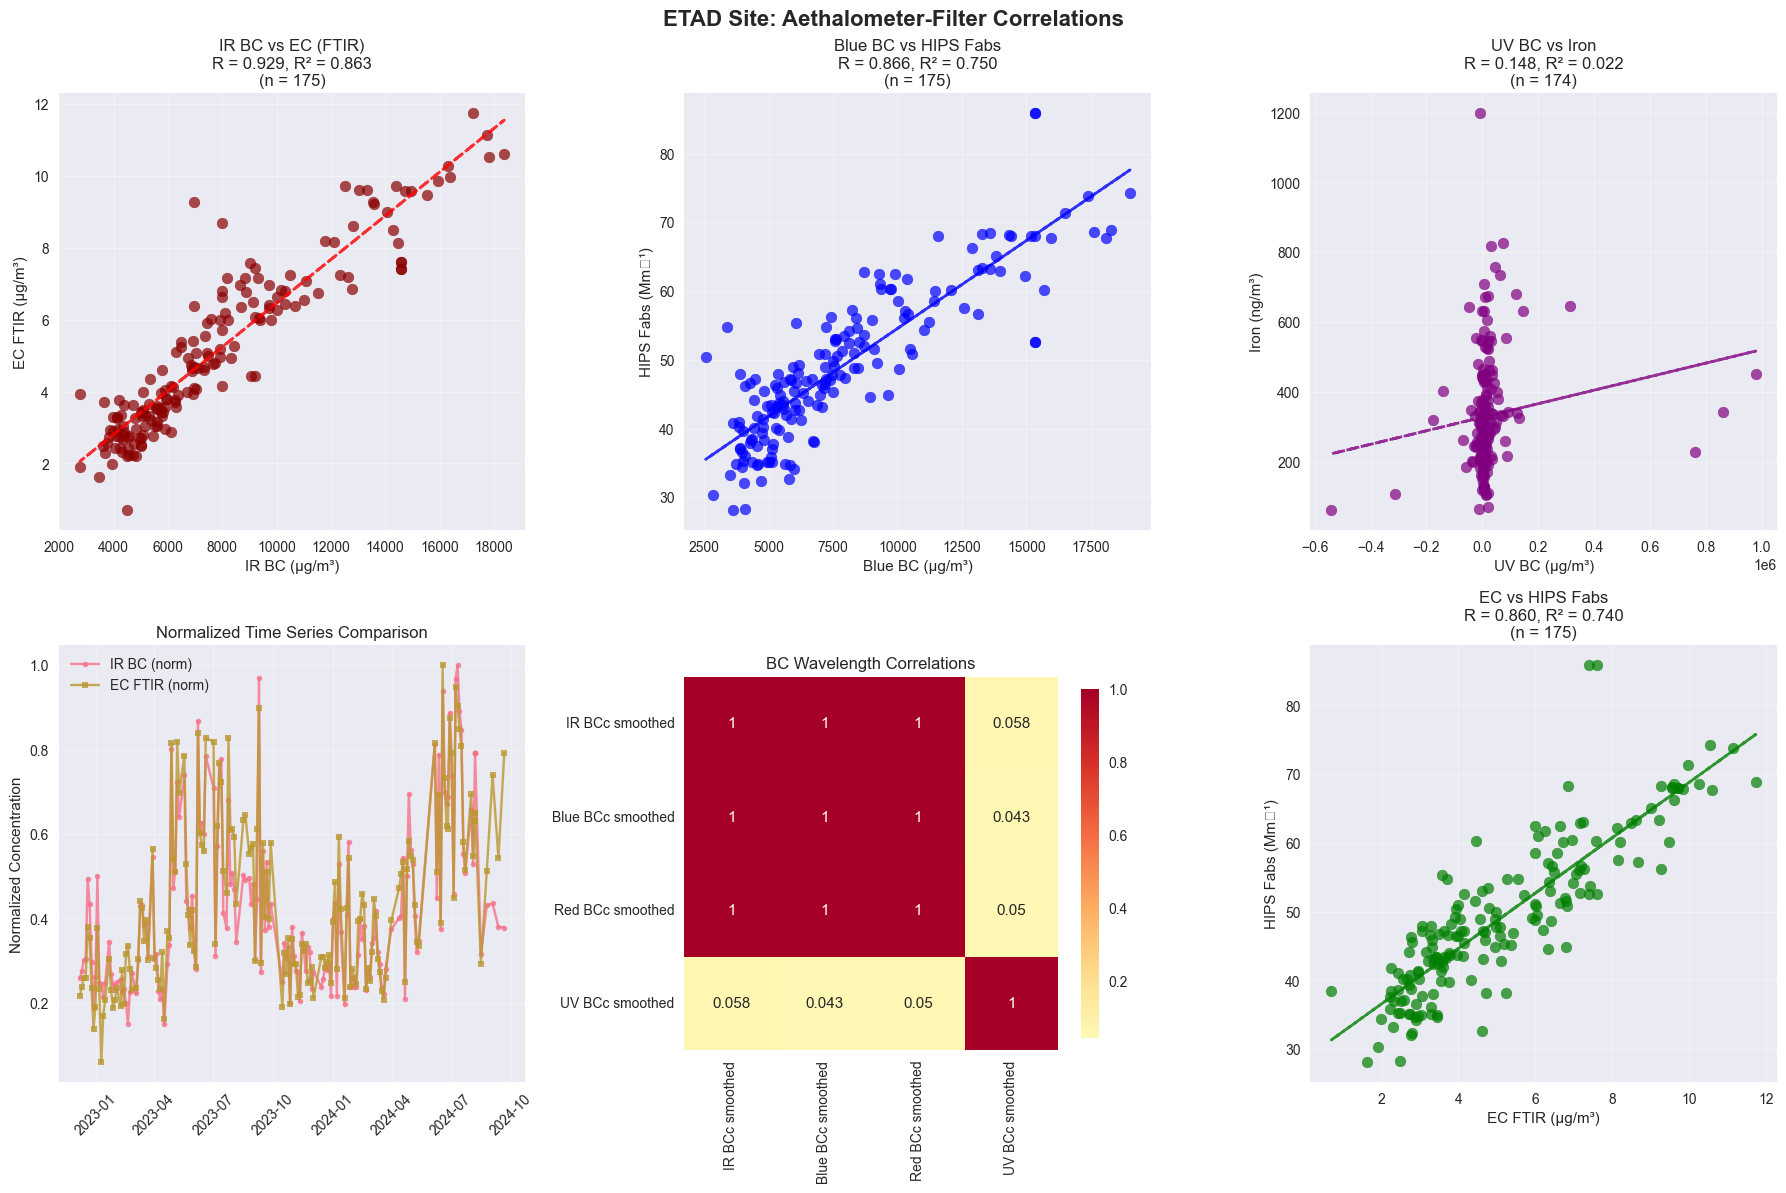

In [7]:
# Create comprehensive correlation plots
if merged_data is not None and len(merged_data) > 0:
    print("📈 Creating correlation analysis plots...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ETAD Site: Aethalometer-Filter Correlations', fontsize=16, fontweight='bold')
    
    # Plot 1: IR BC vs EC_ftir
    ax1 = axes[0, 0]
    if 'IR BCc smoothed' in merged_data.columns and 'EC_ftir' in merged_data.columns:
        mask = merged_data[['IR BCc smoothed', 'EC_ftir']].notna().all(axis=1)
        if mask.sum() > 2:
            x = merged_data.loc[mask, 'IR BCc smoothed']
            y = merged_data.loc[mask, 'EC_ftir']
            ax1.scatter(x, y, alpha=0.7, s=60, color='darkred')
            
            # Add regression line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax1.plot(x, p(x), "r--", alpha=0.8, linewidth=2)
            
            # Add correlation coefficient
            corr = x.corr(y)
            r2 = corr**2
            ax1.set_title(f'IR BC vs EC (FTIR)\nR = {corr:.3f}, R² = {r2:.3f}\n(n = {len(x)})')
            ax1.set_xlabel('IR BC (μg/m³)')
            ax1.set_ylabel('EC FTIR (μg/m³)')
        else:
            ax1.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                    transform=ax1.transAxes, ha='center', va='center')
            ax1.set_title('IR BC vs EC (FTIR)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Blue BC vs HIPS_Fabs
    ax2 = axes[0, 1]
    if 'Blue BCc smoothed' in merged_data.columns and 'HIPS_Fabs' in merged_data.columns:
        mask = merged_data[['Blue BCc smoothed', 'HIPS_Fabs']].notna().all(axis=1)
        if mask.sum() > 2:
            x = merged_data.loc[mask, 'Blue BCc smoothed']
            y = merged_data.loc[mask, 'HIPS_Fabs']
            ax2.scatter(x, y, alpha=0.7, s=60, color='blue')
            
            # Add regression line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax2.plot(x, p(x), "b--", alpha=0.8, linewidth=2)
            
            corr = x.corr(y)
            r2 = corr**2
            ax2.set_title(f'Blue BC vs HIPS Fabs\nR = {corr:.3f}, R² = {r2:.3f}\n(n = {len(x)})')
            ax2.set_xlabel('Blue BC (μg/m³)')
            ax2.set_ylabel('HIPS Fabs (Mm⁻¹)')
        else:
            ax2.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                    transform=ax2.transAxes, ha='center', va='center')
            ax2.set_title('Blue BC vs HIPS Fabs')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: UV BC vs Iron
    ax3 = axes[0, 2]
    if 'UV BCc smoothed' in merged_data.columns and 'Iron_ChemSpec' in merged_data.columns:
        mask = merged_data[['UV BCc smoothed', 'Iron_ChemSpec']].notna().all(axis=1)
        if mask.sum() > 2:
            x = merged_data.loc[mask, 'UV BCc smoothed']
            y = merged_data.loc[mask, 'Iron_ChemSpec']
            ax3.scatter(x, y, alpha=0.7, s=60, color='purple')
            
            # Add regression line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax3.plot(x, p(x), "purple", linestyle='--', alpha=0.8, linewidth=2)
            
            corr = x.corr(y)
            r2 = corr**2
            ax3.set_title(f'UV BC vs Iron\nR = {corr:.3f}, R² = {r2:.3f}\n(n = {len(x)})')
            ax3.set_xlabel('UV BC (μg/m³)')
            ax3.set_ylabel('Iron (ng/m³)')
        else:
            ax3.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                    transform=ax3.transAxes, ha='center', va='center')
            ax3.set_title('UV BC vs Iron')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Time series comparison (normalized)
    ax4 = axes[1, 0]
    if 'datetime_local' in merged_data.columns:
        dates = merged_data['datetime_local']
        
        # Plot normalized time series for visual comparison
        if 'IR BCc smoothed' in merged_data.columns and merged_data['IR BCc smoothed'].notna().sum() > 0:
            ir_data = merged_data['IR BCc smoothed'].dropna()
            ir_norm = ir_data / ir_data.max()
            ax4.plot(dates[merged_data['IR BCc smoothed'].notna()], ir_norm, 
                    'o-', label='IR BC (norm)', alpha=0.8, markersize=4)
        
        if 'EC_ftir' in merged_data.columns and merged_data['EC_ftir'].notna().sum() > 0:
            ec_data = merged_data['EC_ftir'].dropna()
            ec_norm = ec_data / ec_data.max()
            ax4.plot(dates[merged_data['EC_ftir'].notna()], ec_norm, 
                    's-', label='EC FTIR (norm)', alpha=0.8, markersize=4)
        
        ax4.set_title('Normalized Time Series Comparison')
        ax4.set_ylabel('Normalized Concentration')
        ax4.legend()
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Multi-wavelength BC correlation matrix
    ax5 = axes[1, 1]
    bc_cols = ['IR BCc smoothed', 'Blue BCc smoothed', 'Red BCc smoothed', 'UV BCc smoothed']
    bc_available = [col for col in bc_cols if col in merged_data.columns]
    
    if len(bc_available) > 1:
        corr_matrix = merged_data[bc_available].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
                   square=True, ax=ax5, cbar_kws={'shrink': 0.8})
        ax5.set_title('BC Wavelength Correlations')
    else:
        ax5.text(0.5, 0.5, 'Insufficient BC\nwavelength data', 
                transform=ax5.transAxes, ha='center', va='center')
        ax5.set_title('BC Wavelength Correlations')
    
    # Plot 6: EC vs Fabs correlation
    ax6 = axes[1, 2]
    if 'EC_ftir' in merged_data.columns and 'HIPS_Fabs' in merged_data.columns:
        mask = merged_data[['EC_ftir', 'HIPS_Fabs']].notna().all(axis=1)
        if mask.sum() > 2:
            x = merged_data.loc[mask, 'EC_ftir']
            y = merged_data.loc[mask, 'HIPS_Fabs']
            ax6.scatter(x, y, alpha=0.7, s=60, color='green')
            
            # Add regression line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax6.plot(x, p(x), "g--", alpha=0.8, linewidth=2)
            
            corr = x.corr(y)
            r2 = corr**2
            ax6.set_title(f'EC vs HIPS Fabs\nR = {corr:.3f}, R² = {r2:.3f}\n(n = {len(x)})')
            ax6.set_xlabel('EC FTIR (μg/m³)')
            ax6.set_ylabel('HIPS Fabs (Mm⁻¹)')
        else:
            ax6.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                    transform=ax6.transAxes, ha='center', va='center')
            ax6.set_title('EC vs HIPS Fabs')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ETAD_aethalometer_filter_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ No merged data available for visualization")

## 6. Summary Statistics and Data Export

In [8]:
# Generate summary statistics
if merged_data is not None and len(merged_data) > 0:
    print("📊 ETAD Aethalometer-Filter Matching Summary")
    print("=" * 60)
    
    # Basic dataset info
    print(f"📅 Analysis period: {merged_data['match_date'].min()} to {merged_data['match_date'].max()}")
    print(f"📊 Total matched records: {len(merged_data)}")
    
    # Summary statistics for key parameters
    stats_cols = []
    for col in ['IR BCc smoothed', 'Blue BCc smoothed', 'Red BCc smoothed', 'UV BCc smoothed', 
                'EC_ftir', 'HIPS_Fabs', 'Iron_ChemSpec']:
        if col in merged_data.columns and merged_data[col].notna().sum() > 0:
            stats_cols.append(col)
    
    if len(stats_cols) > 0:
        print(f"\n📈 Descriptive Statistics:")
        summary_stats = merged_data[stats_cols].describe()
        print(summary_stats.round(3))
        
        # Correlation matrix
        print(f"\n🔗 Correlation Matrix:")
        corr_matrix = merged_data[stats_cols].corr()
        print(corr_matrix.round(3))
        
        # Data completeness
        print(f"\n📊 Data Completeness:")
        for col in stats_cols:
            count = merged_data[col].notna().sum()
            percentage = (count / len(merged_data)) * 100
            print(f"   {col:<20}: {count:3d}/{len(merged_data)} ({percentage:5.1f}%)")
    
    # Key correlations summary
    print(f"\n🎯 Key Correlations Summary:")
    key_pairs = [
        ('IR BCc smoothed', 'EC_ftir', 'IR BC vs EC'),
        ('Blue BCc smoothed', 'HIPS_Fabs', 'Blue BC vs Fabs'),
        ('UV BCc smoothed', 'Iron_ChemSpec', 'UV BC vs Iron'),
        ('EC_ftir', 'HIPS_Fabs', 'EC vs Fabs')
    ]
    
    for col1, col2, label in key_pairs:
        if col1 in merged_data.columns and col2 in merged_data.columns:
            mask = merged_data[[col1, col2]].notna().all(axis=1)
            if mask.sum() > 2:
                corr = merged_data.loc[mask, col1].corr(merged_data.loc[mask, col2])
                r2 = corr**2
                n = mask.sum()
                print(f"   {label:<15}: R = {corr:6.3f}, R² = {r2:6.3f} (n = {n})")
    
    print(f"\n💾 Data Export:")
    
    # Save complete merged dataset
    full_output_path = 'ETAD_aethalometer_filter_matched_complete.pkl'
    merged_data.to_pickle(full_output_path)
    print(f"   Complete dataset: {full_output_path}")
    
    # Save analysis subset as CSV
    analysis_cols = ['match_date', 'datetime_local'] + stats_cols
    available_analysis_cols = [col for col in analysis_cols if col in merged_data.columns]
    
    csv_output_path = 'ETAD_aethalometer_filter_matched_analysis.csv'
    merged_data[available_analysis_cols].to_csv(csv_output_path, index=False)
    print(f"   Analysis dataset: {csv_output_path}")
    print(f"   Correlation plot: ETAD_aethalometer_filter_correlations.png")
    
    print(f"\n✅ Analysis complete! Found {len(merged_data)} matched samples for ETAD site.")
else:
    print("❌ No data available for summary statistics")

📊 ETAD Aethalometer-Filter Matching Summary
📅 Analysis period: 2022-12-07 to 2024-09-21
📊 Total matched records: 175

📈 Descriptive Statistics:
       IR BCc smoothed  Blue BCc smoothed  Red BCc smoothed  UV BCc smoothed  \
count          175.000            175.000           175.000          175.000   
mean          7789.462           7875.321          7740.226        22219.104   
std           3610.215           3739.943          3613.989       129459.128   
min           2756.938           2556.257          2608.842      -540314.000   
25%           5027.196           5117.103          5023.174        -1326.462   
50%           6881.801           6958.483          6797.151         6628.672   
75%           9372.762           9689.121          9170.765        20226.751   
max          18383.942          19022.578         18059.747       979363.892   

       EC_ftir  HIPS_Fabs  Iron_ChemSpec  
count  175.000    175.000        174.000  
mean     5.113     49.119        331.309  
std   